In [5]:
from noise import pnoise2, snoise2
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats

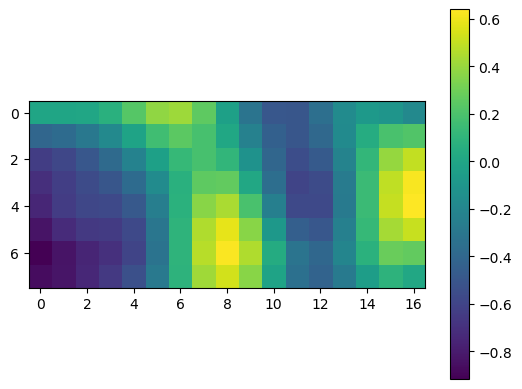

In [2]:
tmp = np.ones((8, 17))
freq = 10
octaves = 1
for y in range(17):
	for x in range(8):
		tmp[x, y] = snoise2(x / freq, y / freq, octaves)
		
plt.imshow(tmp)
plt.colorbar()
plt.show()

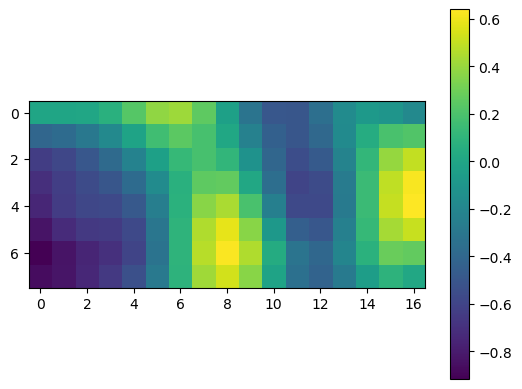

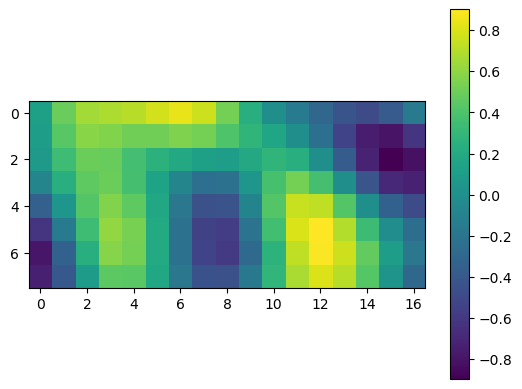

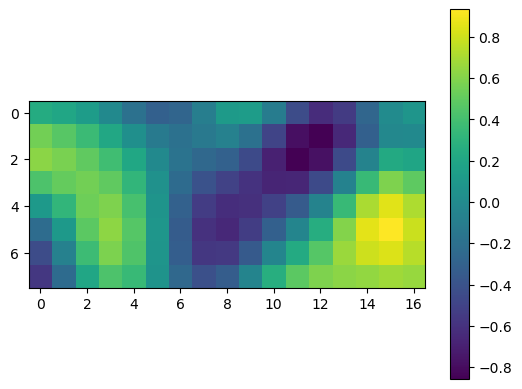

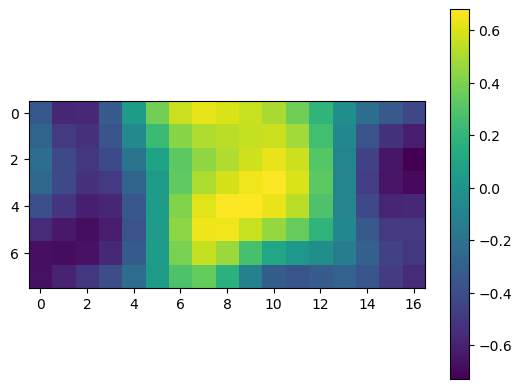

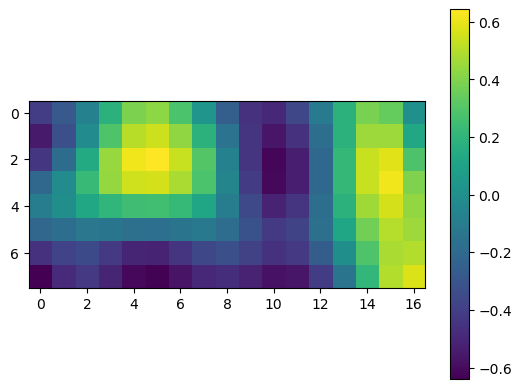

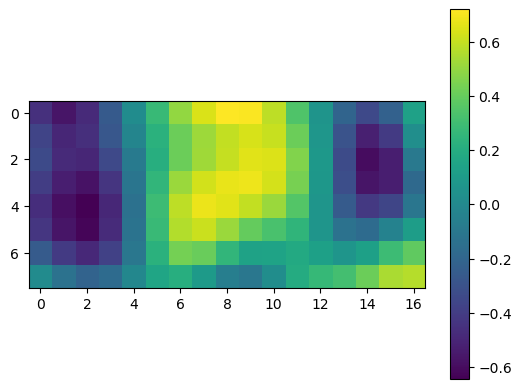

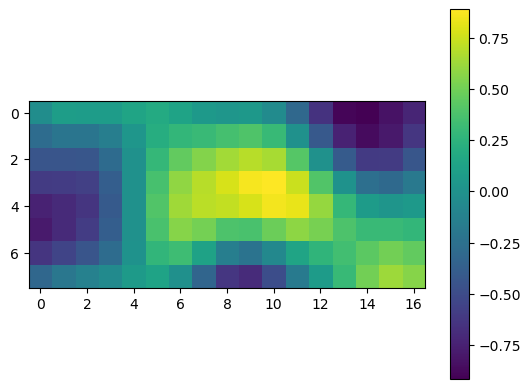

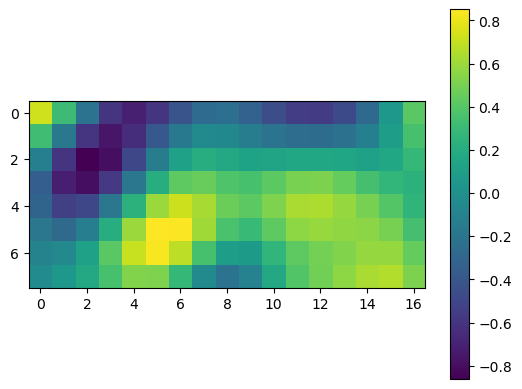

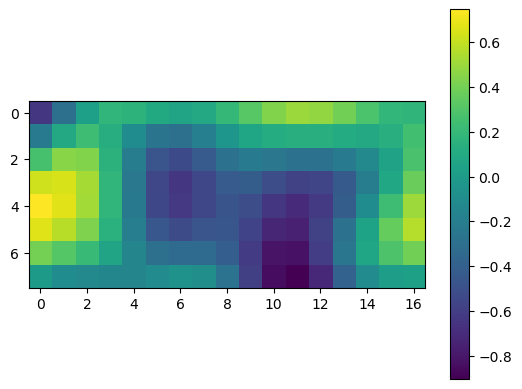

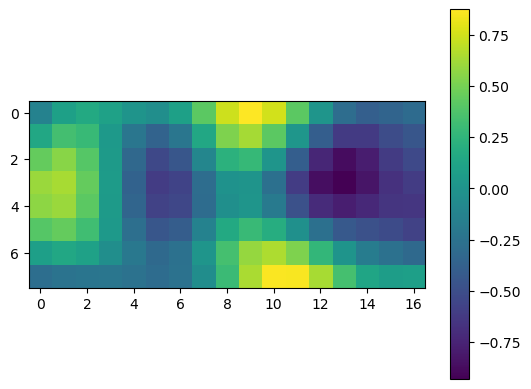

In [3]:
freq = 10
octaves = 1

for i in range(10):
    plt.imshow(np.asarray([[snoise2(x / freq, y / freq, octaves, base=1000*i) for y in range(17)] for x in range(8)]))
    plt.colorbar()
    plt.show()

In [6]:
# only 2 gaussians
def create_p_sample2(x):
  # sampling from Gaussians
  ground_canopy_reg = np.random.uniform(0, 1) # ratio ground vs canopy
  mean0 = np.random.uniform(-5,5)
  std0 = np.random.uniform(0.1,2)
  ground_peak = scipy.stats.norm.pdf(x, mean0, std0)
  gauss_list = ground_canopy_reg*ground_peak/max(ground_peak) # ground reflection

  std1 = np.random.uniform(1,4)
  mean1 = np.random.uniform(max(mean0+std0+2*std1, -2),20)
  crown_peak = scipy.stats.norm.pdf(x, mean1, std1)
  gauss_list += (1-ground_canopy_reg)*crown_peak/max(crown_peak)

  return gauss_list, [mean0, std0, mean1, std1, ground_canopy_reg]

def create_p_sample_fromheight(x, mean0, mean1, ground_canopy_reg):
  # sampling from Gaussians
  std0 = np.random.uniform(0.1,2)
  ground_peak = scipy.stats.norm.pdf(x, mean0, std0)
  gauss_list = ground_canopy_reg*ground_peak/max(ground_peak) # ground reflection

  std1 = np.random.uniform(1,4)
  crown_peak = scipy.stats.norm.pdf(x, mean1, std1)
  gauss_list += (1-ground_canopy_reg)*crown_peak/max(crown_peak)

  return gauss_list, [mean0, std0, mean1, std1, ground_canopy_reg]

In [8]:
### simulate reflectivity vectors
Nz = 512 # number of discrete heights
z = np.linspace(-10, 30, Nz) # heights
Nsamples = 10000
random_seed = 0
p = []
parameters = []
np.random.seed(random_seed)
for i in range(Nsamples):
  if i%1000 == 0:
    print(i)
  pdf, param = create_p_sample2(z)
  p.append(pdf)
  parameters.append(param)

# normalisation - to obtain APA normalised
p_norm = np.transpose(np.asarray(p)/np.sum(p, axis=1).reshape(-1, 1))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [ ]:
import matplotlib as mpl
mpl.rc('image', cmap='jet')
plt.rcParams.update({'font.size': 30})

0.0
1.084961932832344


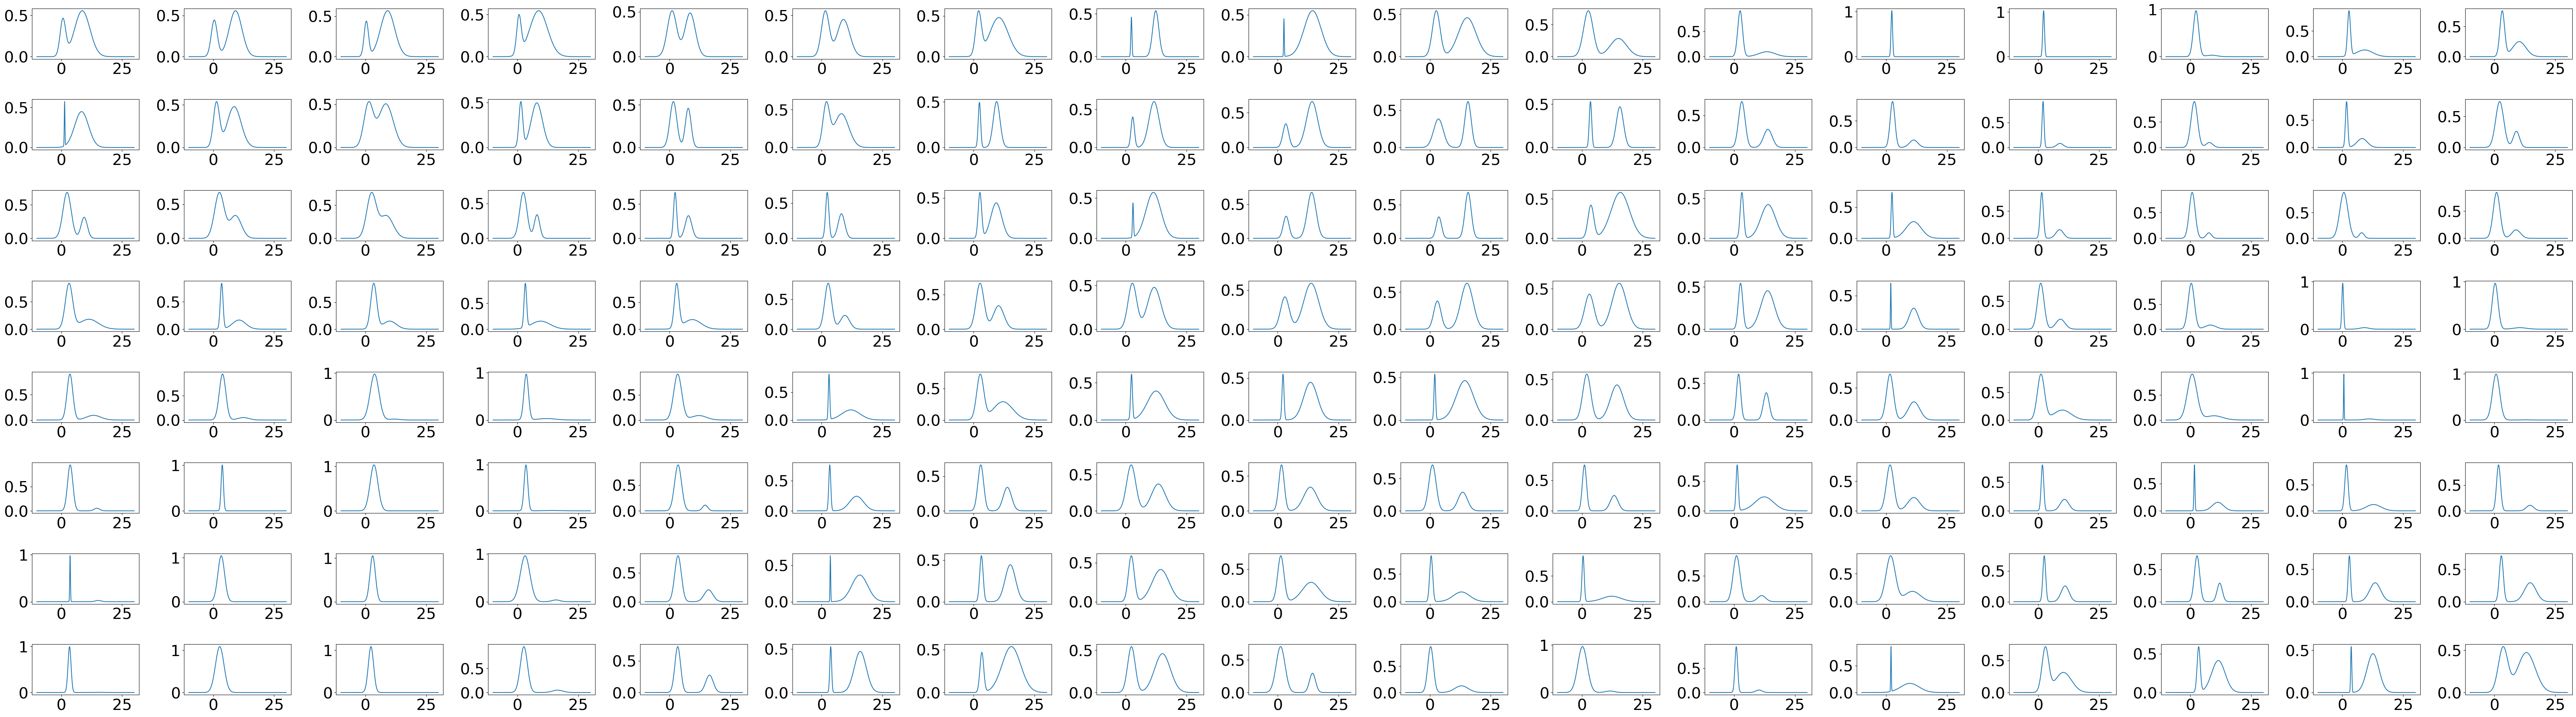

In [40]:
def create_neighbors(parameter, Wrg, Waz, z, freq=10, octaves=1, index=0):
  mean0, _, mean1, _, ground_canopy_reg = parameter
  ground = np.asarray([[snoise2(x / freq, y / freq, octaves, base=(index+1)) for y in range(Waz)] for x in range(Wrg)]) * np.abs(5-np.abs(mean0))
  ground = ground - ground[int(Wrg/2), int(Waz/2)] + mean0
  crown = np.asarray([[snoise2(x / freq, y / freq, octaves, base=(index+1)*10) for y in range(Waz)] for x in range(Wrg)]) * min(20-np.abs(mean1), np.abs(5-np.abs(mean1)))
  crown = crown - crown[int(Wrg/2), int(Waz/2)] + mean1
  ratio = np.asarray([[snoise2(x / freq, y / freq, octaves, base=(index+1)*50) for y in range(Waz)] for x in range(Wrg)]) * min(1-np.abs(ground_canopy_reg), np.abs(ground_canopy_reg))
  ratio = ratio - ratio[int(Wrg/2), int(Waz/2)] + ground_canopy_reg
  return np.clip([[create_p_sample_fromheight(z, ground[i,j], crown[i,j], ratio[i,j])[0] for j in range(Waz)] for i in range(Wrg)], 0, None)

np.random.seed(random_seed)
Wrg = 8
Waz = 17
ne  = create_neighbors(parameters[0], Wrg, Waz, z, index=0)

print(np.min(ne))
print(np.max(ne))
fig, axs = plt.subplots(ne.shape[0], ne.shape[1], figsize=(70, 20))
for n in range(len(ne)):
  for i in range(ne.shape[1]):
    axs[n,i].plot(z, ne[n,i])
fig.tight_layout()
plt.show()

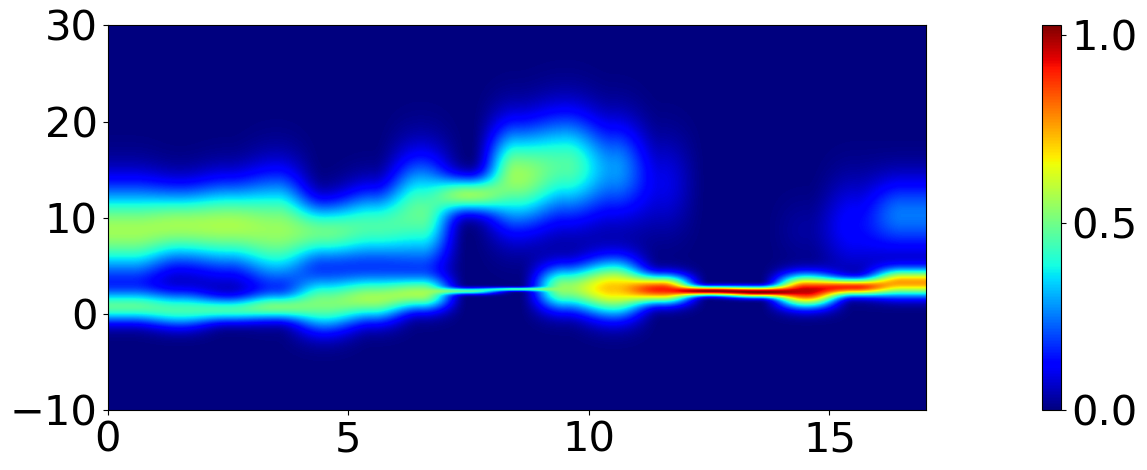

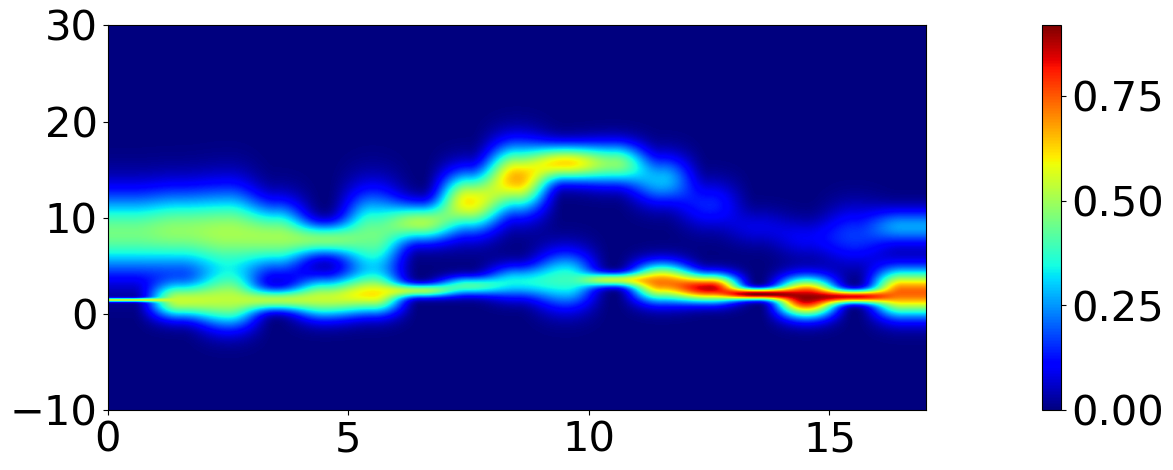

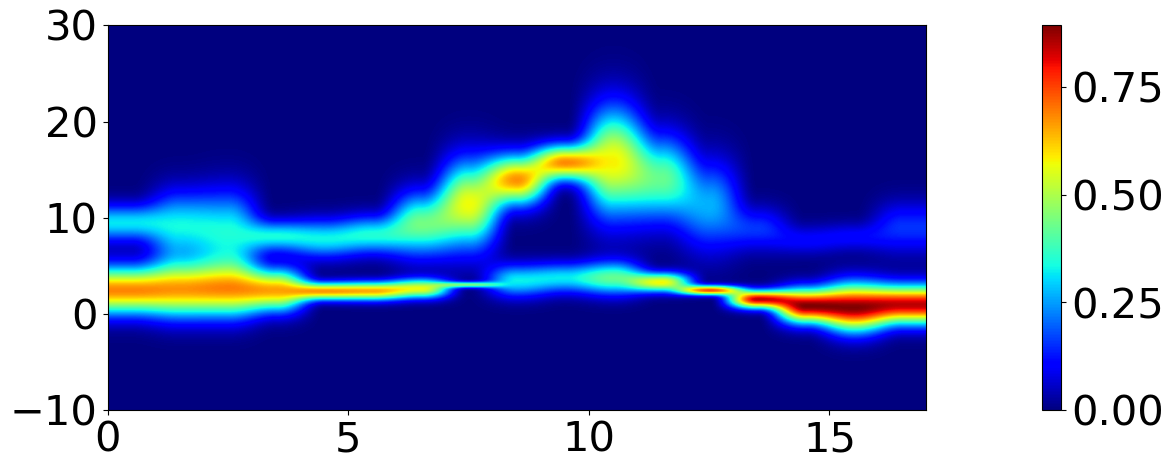

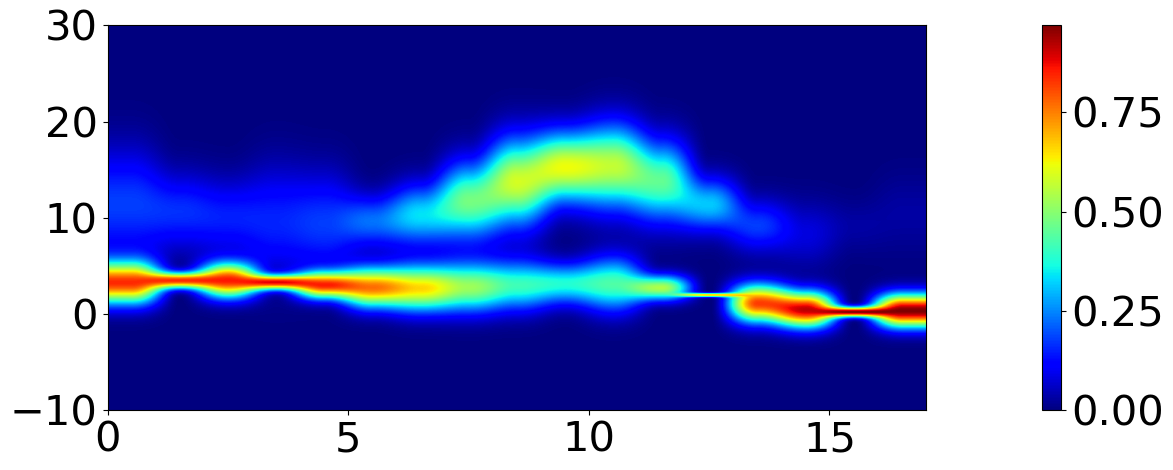

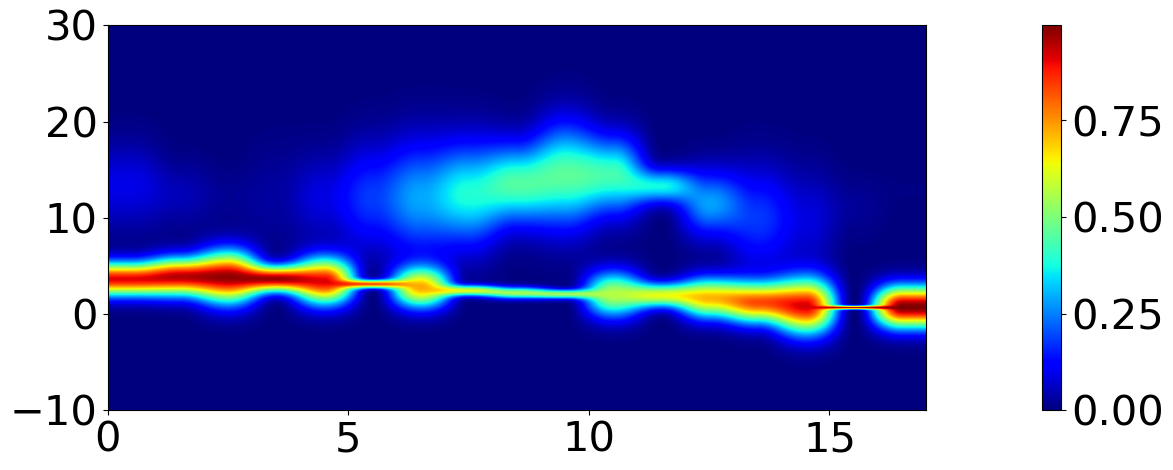

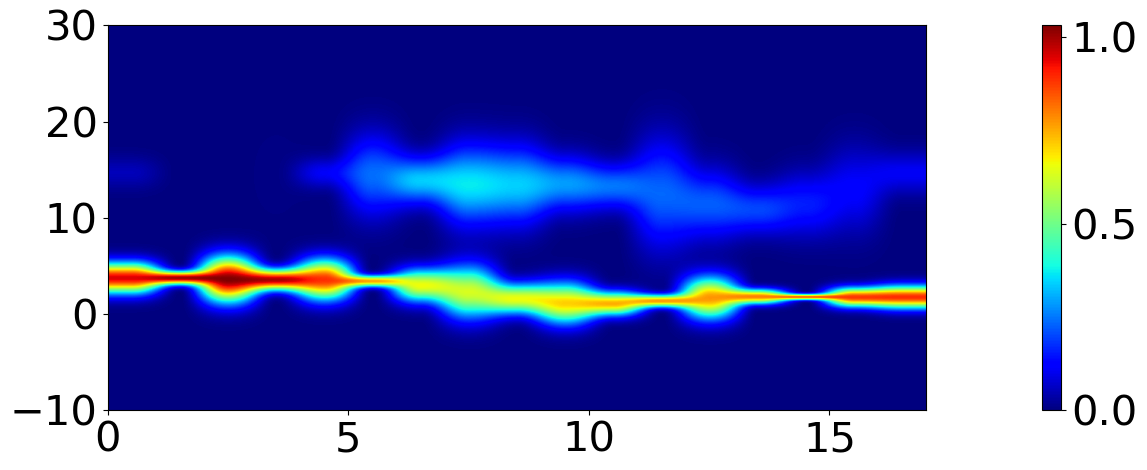

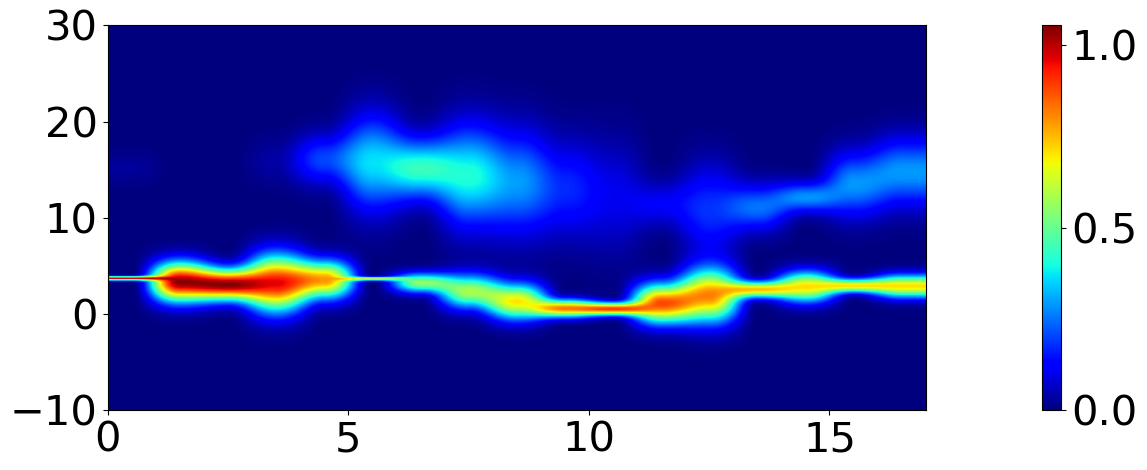

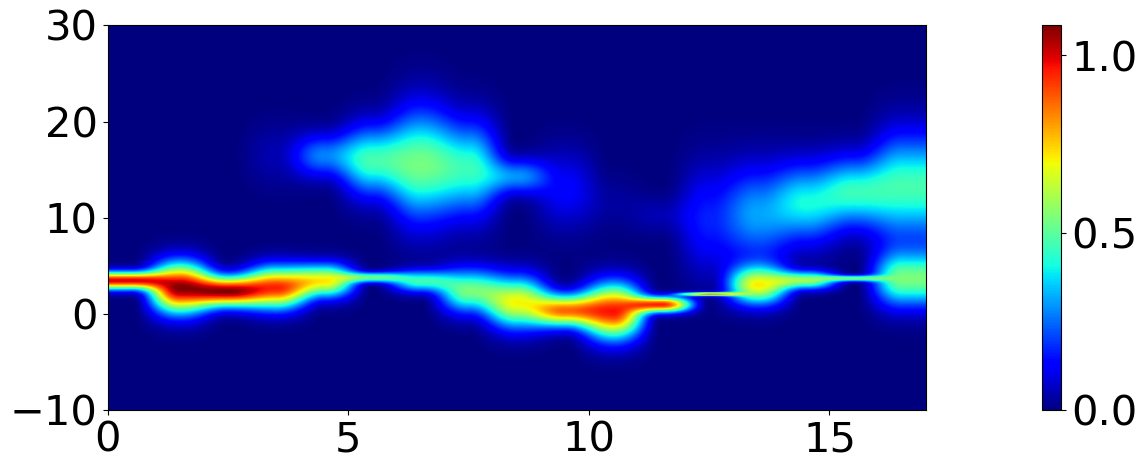

In [38]:
for n in ne:
    plt.figure(figsize=(30,5))
    plt.imshow(n.T, extent=[0,n.shape[0],min(z),max(z)], origin='lower')
    plt.gca().set_aspect(.2)
    plt.colorbar()
    plt.show()


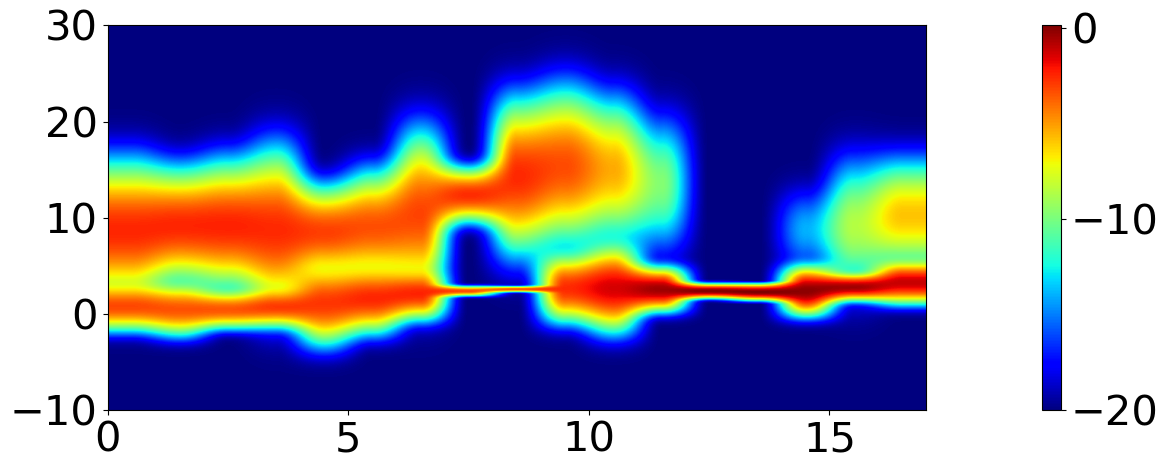

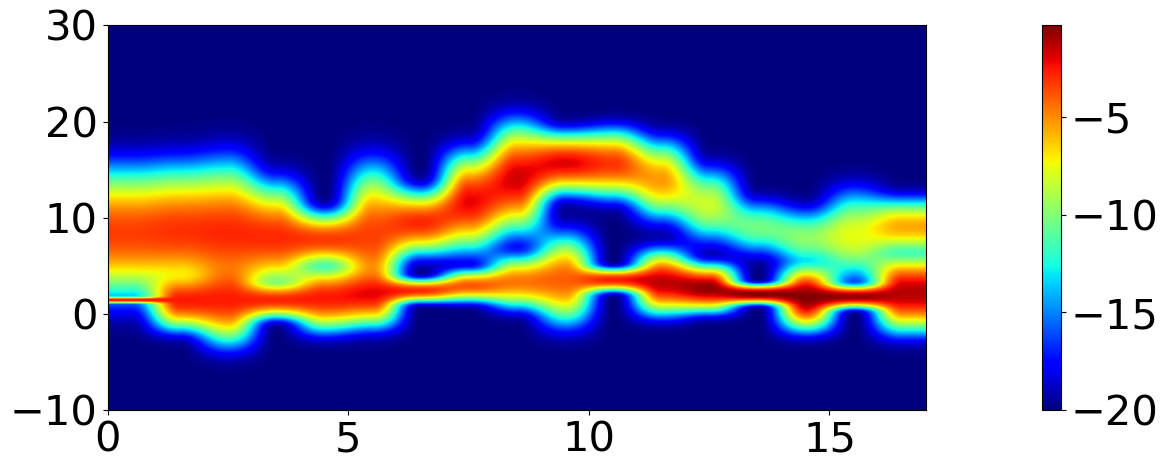

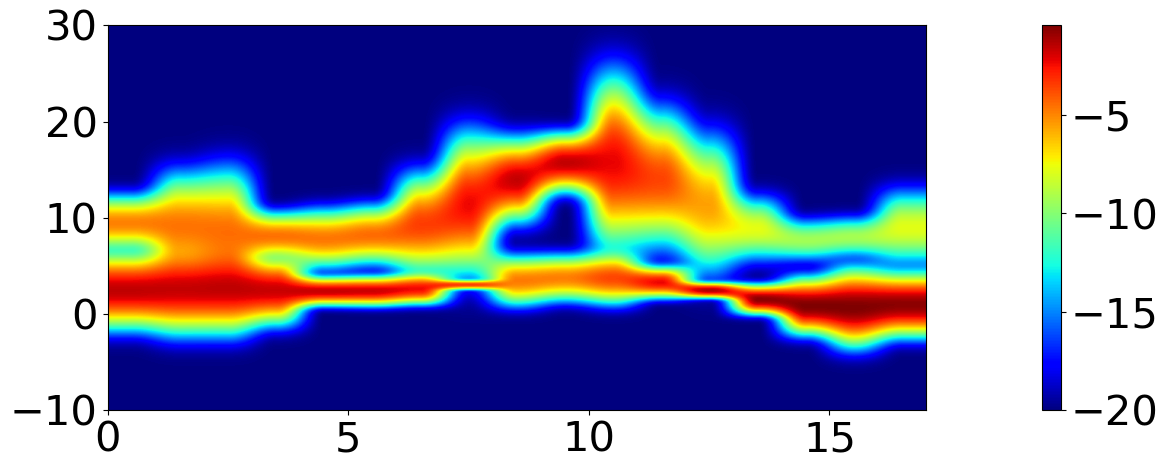

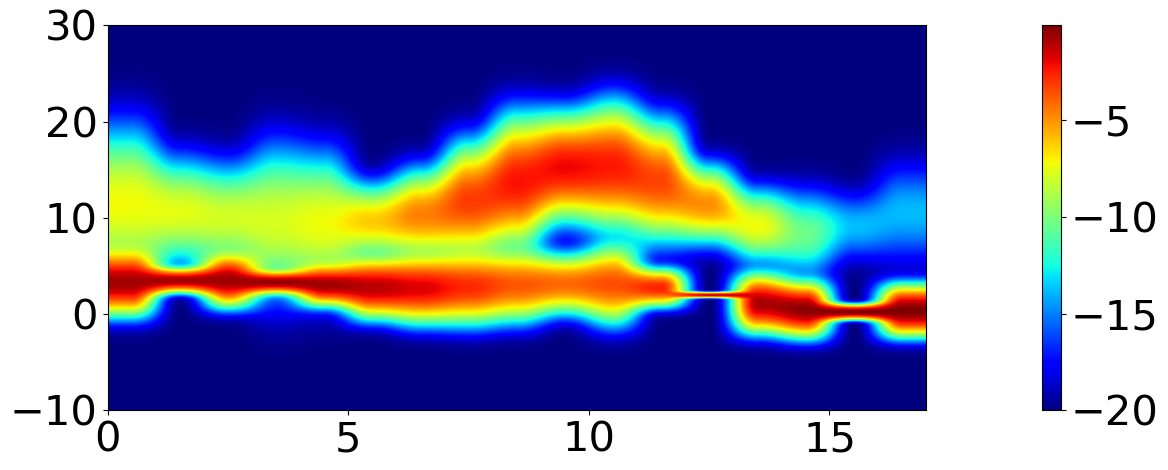

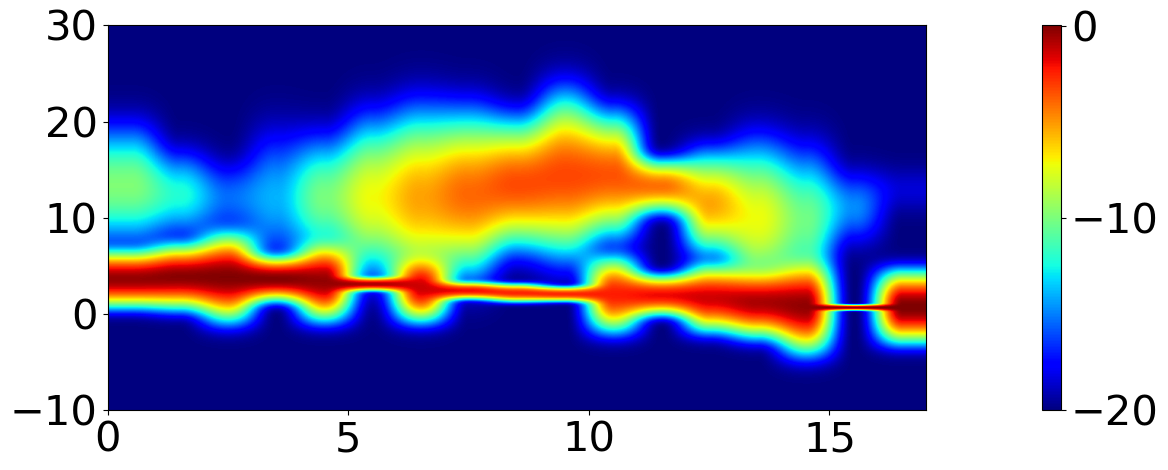

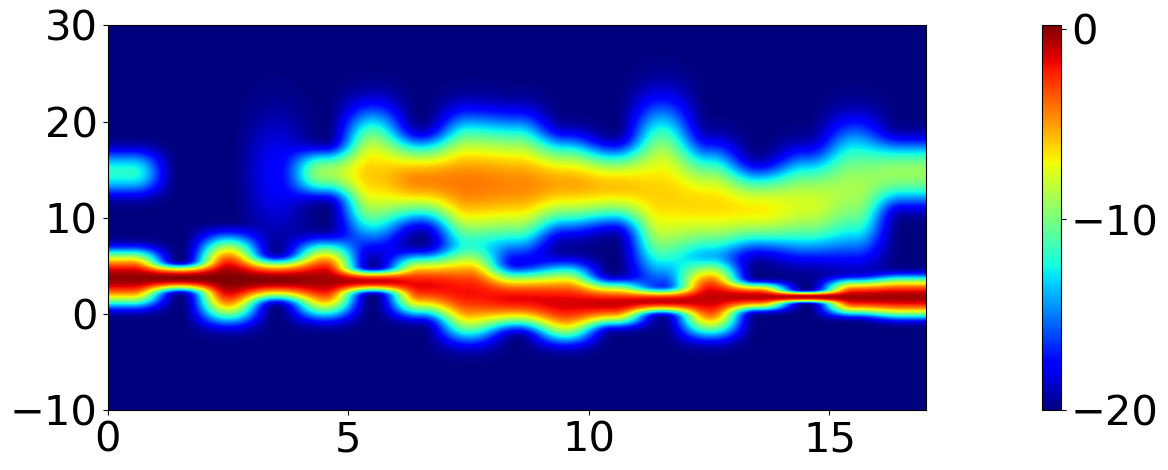

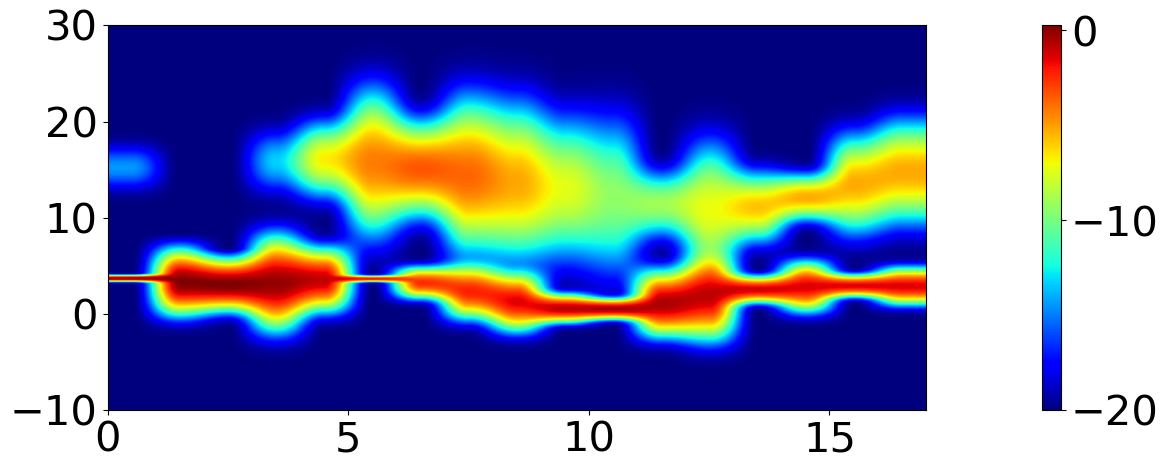

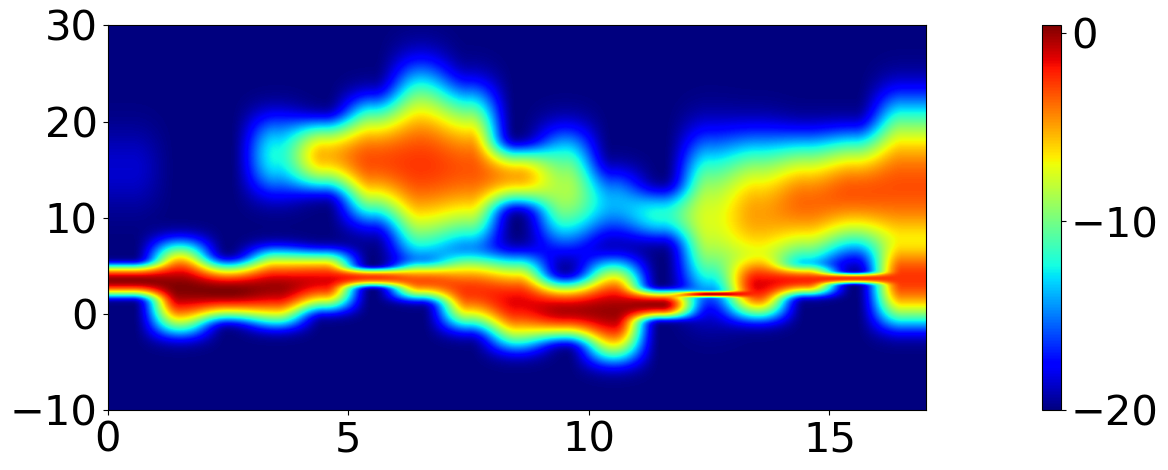

In [37]:
for n in ne:
    plt.figure(figsize=(30,5))
    plt.imshow(10*np.log10(n.T+1e-2), extent=[0,n.shape[0],min(z),max(z)], origin='lower')
    plt.gca().set_aspect(.2)
    plt.colorbar()
    plt.show()


In [42]:
p_neighbors = [create_neighbors(parameters[i], Wrg, Waz, z, index=i) for i in range(Nsamples)]
np.asarray(p_neighbors).shape

(10000, 8, 17, 512)

In [54]:
import math
def create_z_samples_neighbors(p, r_a_coord_index, kz, z, Nlook, Wrg, Waz, epsilon=1e-2):
  range_rg = np.clip(range(r_a_coord_index[0]+math.ceil(-Wrg/2), r_a_coord_index[0]+math.ceil(Wrg/2)), 0, kz.shape[0]-1)
  range_az = np.clip(range(r_a_coord_index[1]+math.ceil(-Waz/2), r_a_coord_index[1]+math.ceil(Waz/2)), 0, kz.shape[1]-1)
  Nim = kz.shape[2]

  # create independent samples from theoretic p profiles
  zsim = np.zeros((len(range_rg), len(range_az), Nim, Nlook), dtype=np.complex64)
  for i in range(len(range_rg)):
    for j in range(len(range_az)):
      A = np.transpose(np.exp(-1j*z.reshape(-1,1).dot(kz[range_rg[i], range_az[j], :].reshape(1,-1))))
      C = A @ np.diag(p[i, j]/np.sum(p[i, j])) @ np.conj(np.transpose(A)) + epsilon * np.eye(Nim)
      L = np.linalg.cholesky(C)
      noise = np.random.randn(Nim, Nlook)/np.sqrt(2) + 1j*np.random.randn(Nim, Nlook)/np.sqrt(2)
      zsim[i,j] = L @ noise

  return zsim

kz = np.ones((800, 1300, 6))
zn = create_z_samples_neighbors(p_neighbors[0], [400, 1000], kz, z, 1, epsilon=1e-2)
print(zn.shape)
print(np.squeeze(zn).shape)


(8, 17, 6, 1)
(8, 17, 6)
